In [1]:
import numpy as np
import json
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('train_test.json', 'r') as file:
    train_test = json.load(file)

In [3]:
def load_and_normalize_images(image_paths):
    arrays = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        arr = np.array(img, dtype=np.float32)
        
        arr = arr / 255.0
        arrays.append(arr)
    
    return np.stack(arrays, axis=0)

In [4]:
X_train_arr = load_and_normalize_images(train_test['X_train'])
X_test_arr = load_and_normalize_images(train_test['X_test'])

In [5]:
print(X_train_arr.shape)
print(X_test_arr.shape)

(3904, 36, 36, 3)
(976, 36, 36, 3)


In [6]:
X_train_flat = X_train_arr.reshape((X_train_arr.shape[0], -1))
X_test_flat = X_test_arr.reshape((X_test_arr.shape[0], -1))

In [7]:
print(X_train_flat.shape)
print(X_test_flat.shape)

(3904, 3888)
(976, 3888)


In [8]:
y_train = np.array(train_test['y_train'])
y_test = np.array(train_test['y_test'])

In [9]:
print(y_train.shape)
print(y_test.shape)

(3904,)
(976,)


In [10]:
y_train[:5]

array([0, 1, 1, 1, 1])

In [11]:
pca = PCA()
pca.fit(X_train_flat)

PCA()

In [12]:
exp_var = pca.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)

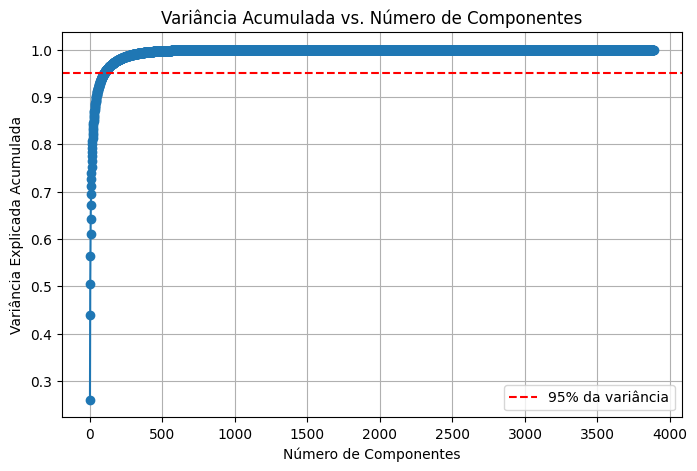

In [13]:
plt.figure(figsize=(8,5))
plt.plot(cum_exp_var, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Acumulada vs. Número de Componentes')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% da variância')
plt.legend()
plt.show()

In [14]:
threshold = 0.95
n_components_95 = np.argmax(cum_exp_var >= threshold) + 1
print("Número de componentes para atingir 95% da variância:", n_components_95)

Número de componentes para atingir 95% da variância: 99


In [15]:
pca = PCA(n_components=n_components_95)
pca.fit(X_train_flat)

X_train_pca = pca.transform(X_train_flat)

X_test_pca = pca.transform(X_test_flat)

In [94]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(3904, 99)
(976, 99)


In [16]:
print("Formato original X_train:", X_train_flat.shape)
print("Formato PCA X_train:", X_train_pca.shape)
print("Formato original X_test:", X_test_flat.shape)
print("Formato PCA X_test:", X_test_pca.shape)

Formato original X_train: (3904, 3888)
Formato PCA X_train: (3904, 99)
Formato original X_test: (976, 3888)
Formato PCA X_test: (976, 99)


In [17]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['WBC', 'RBC', 'Platelets'], yticklabels=['WBC', 'RBC', 'Platelets'])
    plt.xlabel('Output Previsto')
    plt.ylabel('Output Real')
    plt.title(title)
    plt.show()

In [18]:
bayes_clf_1 = GaussianNB()
bayes_clf_1.fit(X_train_flat, y_train)
y_pred_bayes_flat = bayes_clf_1.predict(X_test_flat)

print("Resultados - Classificador Bayes com vetores de características originais:")
print(classification_report(y_test, y_pred_bayes_flat, digits=4))

Resultados - Classificador Bayes com vetores de características originais:
              precision    recall  f1-score   support

           0     0.8202    1.0000    0.9012        73
           1     1.0000    0.9795    0.9897       831
           2     0.7671    0.7778    0.7724        72

    accuracy                         0.9662       976
   macro avg     0.8624    0.9191    0.8878       976
weighted avg     0.9694    0.9662    0.9670       976



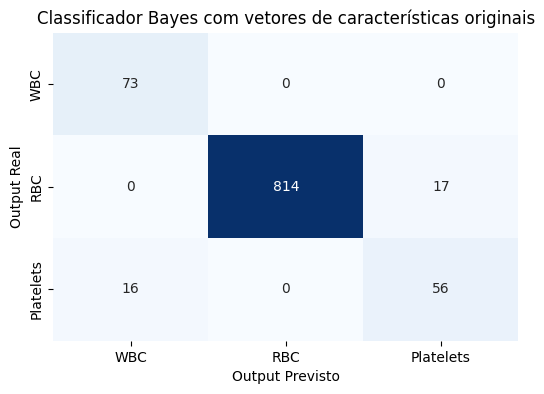

In [19]:
plot_confusion_matrix(y_test, y_pred_bayes_flat, "Classificador Bayes com vetores de características originais")

In [20]:
bayes_clf_2 = GaussianNB()
bayes_clf_2.fit(X_train_pca, y_train)
y_pred_bayes = bayes_clf_2.predict(X_test_pca)

print("Resultados - Classificador Bayes com PCA")
print(classification_report(y_test, y_pred_bayes, digits=4))

Resultados - Classificador Bayes com PCA
              precision    recall  f1-score   support

           0     0.7374    1.0000    0.8488        73
           1     1.0000    0.9711    0.9853       831
           2     0.9714    0.9444    0.9577        72

    accuracy                         0.9713       976
   macro avg     0.9029    0.9719    0.9306       976
weighted avg     0.9782    0.9713    0.9731       976



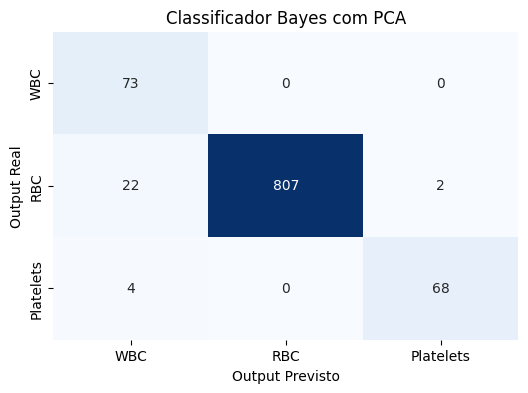

In [21]:
plot_confusion_matrix(y_test, y_pred_bayes, "Classificador Bayes com PCA")

Resultados - Classificador LDA com vetores de características originais
              precision    recall  f1-score   support

           0     1.0000    0.9726    0.9861        73
           1     1.0000    1.0000    1.0000       831
           2     0.9730    1.0000    0.9863        72

    accuracy                         0.9980       976
   macro avg     0.9910    0.9909    0.9908       976
weighted avg     0.9980    0.9980    0.9980       976



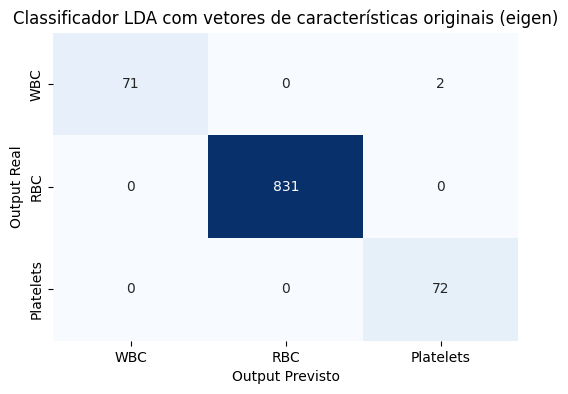

In [22]:
lda_clf_1 = LDA(solver='eigen', shrinkage='auto')
lda_clf_1.fit(X_train_flat, y_train)
y_pred_lda_flat = lda_clf_1.predict(X_test_flat)

print("Resultados - Classificador LDA com vetores de características originais")
print(classification_report(y_test, y_pred_lda_flat, digits=4))
plot_confusion_matrix(y_test, y_pred_lda_flat, "Classificador LDA com vetores de características originais (eigen)")

Resultados - Classificador LDA com vetores de características originais
              precision    recall  f1-score   support

           0     0.2121    0.4795    0.2941        73
           1     0.9305    0.6125    0.7388       831
           2     0.1326    0.4861    0.2083        72

    accuracy                         0.5932       976
   macro avg     0.4251    0.5260    0.4137       976
weighted avg     0.8179    0.5932    0.6664       976



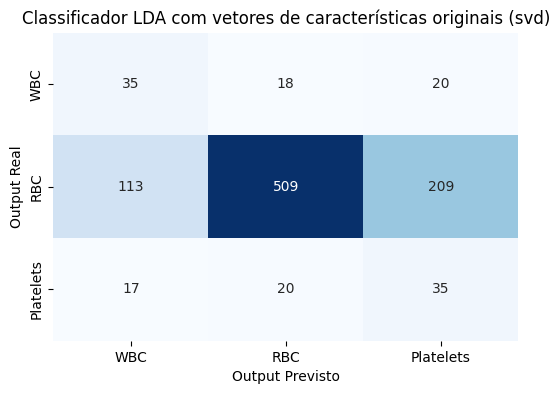

In [23]:
lda_clf_2 = LDA(solver='svd')
lda_clf_2.fit(X_train_flat, y_train)
y_pred_lda_flat_2 = lda_clf_2.predict(X_test_flat)

print("Resultados - Classificador LDA com vetores de características originais")
print(classification_report(y_test, y_pred_lda_flat_2, digits=4))
plot_confusion_matrix(y_test, y_pred_lda_flat_2, "Classificador LDA com vetores de características originais (svd)")

Resultados - Classificador LDA com PCA
              precision    recall  f1-score   support

           0     0.9474    0.9863    0.9664        73
           1     1.0000    1.0000    1.0000       831
           2     0.9855    0.9444    0.9645        72

    accuracy                         0.9949       976
   macro avg     0.9776    0.9769    0.9770       976
weighted avg     0.9950    0.9949    0.9949       976



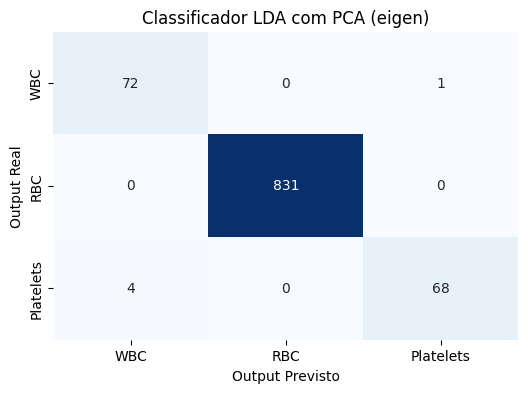

In [24]:
lda_clf_3 = LDA(solver='eigen', shrinkage='auto')
lda_clf_3.fit(X_train_pca, y_train)
y_pred_lda = lda_clf_3.predict(X_test_pca)

print("Resultados - Classificador LDA com PCA")
print(classification_report(y_test, y_pred_lda, digits=4))
plot_confusion_matrix(y_test, y_pred_lda, "Classificador LDA com PCA (eigen)")

Resultados - Classificador LDA com PCA
              precision    recall  f1-score   support

           0     0.9474    0.9863    0.9664        73
           1     0.9988    1.0000    0.9994       831
           2     0.9853    0.9306    0.9571        72

    accuracy                         0.9939       976
   macro avg     0.9772    0.9723    0.9743       976
weighted avg     0.9940    0.9939    0.9938       976



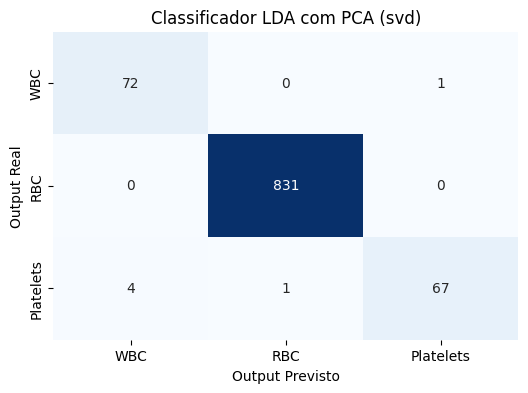

In [25]:
lda_clf_4 = LDA(solver='svd')
lda_clf_4.fit(X_train_pca, y_train)
y_pred_lda_2 = lda_clf_4.predict(X_test_pca)

print("Resultados - Classificador LDA com PCA")
print(classification_report(y_test, y_pred_lda_2, digits=4))
plot_confusion_matrix(y_test, y_pred_lda_2, "Classificador LDA com PCA (svd)")

================ k = 5 =================
Resultados - Classificador KNN com vetores de características originais (k=5)
              precision    recall  f1-score   support

           0     0.9800    0.6712    0.7967        73
           1     1.0000    0.9988    0.9994       831
           2     0.7396    0.9861    0.8452        72

    accuracy                         0.9734       976
   macro avg     0.9065    0.8854    0.8805       976
weighted avg     0.9793    0.9734    0.9729       976



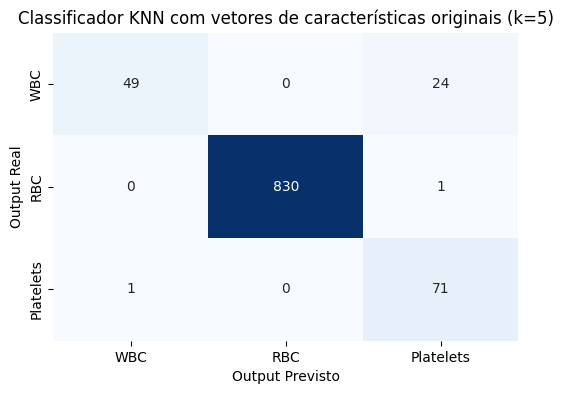

================ k = 7 =================
Resultados - Classificador KNN com vetores de características originais (k=7)
              precision    recall  f1-score   support

           0     1.0000    0.6849    0.8130        73
           1     1.0000    0.9988    0.9994       831
           2     0.7500    1.0000    0.8571        72

    accuracy                         0.9754       976
   macro avg     0.9167    0.8946    0.8898       976
weighted avg     0.9816    0.9754    0.9750       976



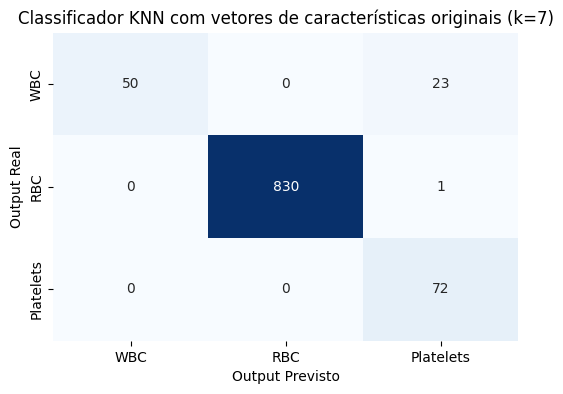

================ k = 11 =================
Resultados - Classificador KNN com vetores de características originais (k=11)
              precision    recall  f1-score   support

           0     1.0000    0.6438    0.7833        73
           1     0.9988    0.9988    0.9988       831
           2     0.7347    1.0000    0.8471        72

    accuracy                         0.9723       976
   macro avg     0.9112    0.8809    0.8764       976
weighted avg     0.9794    0.9723    0.9715       976



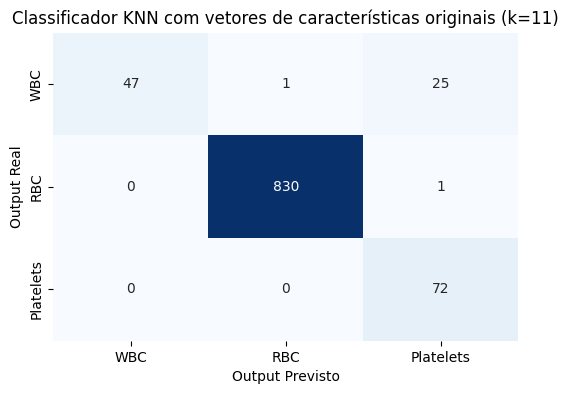

================ k = 13 =================
Resultados - Classificador KNN com vetores de características originais (k=13)
              precision    recall  f1-score   support

           0     1.0000    0.6438    0.7833        73
           1     0.9988    0.9988    0.9988       831
           2     0.7347    1.0000    0.8471        72

    accuracy                         0.9723       976
   macro avg     0.9112    0.8809    0.8764       976
weighted avg     0.9794    0.9723    0.9715       976



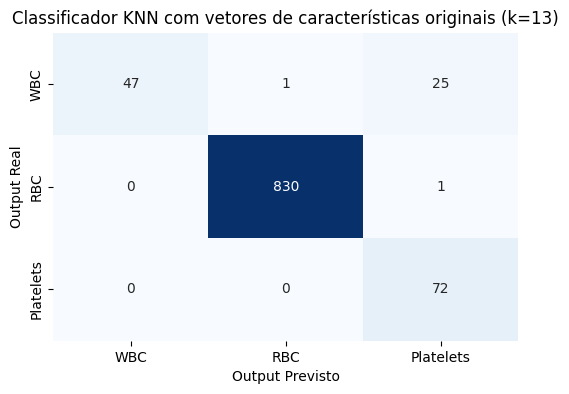

In [26]:
k_neighbors = [5, 7, 11, 13]

for k in k_neighbors:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_flat, y_train)
    y_pred_knn_flat = knn_clf.predict(X_test_flat)

    print(f"================ k = {k} =================")
    print(f"Resultados - Classificador KNN com vetores de características originais (k={k})")
    print(classification_report(y_test, y_pred_knn_flat, digits=4))
    plot_confusion_matrix(y_test, y_pred_knn_flat, f"Classificador KNN com vetores de características originais (k={k})")

================ k = 5 =================
Resultados - Classificador KNN com PCA (k=5)
              precision    recall  f1-score   support

           0     0.9492    0.7671    0.8485        73
           1     1.0000    0.9988    0.9994       831
           2     0.7931    0.9583    0.8679        72

    accuracy                         0.9785       976
   macro avg     0.9141    0.9081    0.9053       976
weighted avg     0.9809    0.9785    0.9784       976



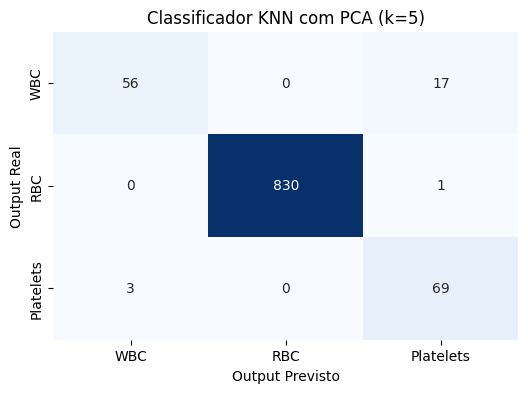

================ k = 7 =================
Resultados - Classificador KNN com PCA (k=7)
              precision    recall  f1-score   support

           0     0.9492    0.7671    0.8485        73
           1     1.0000    0.9988    0.9994       831
           2     0.7931    0.9583    0.8679        72

    accuracy                         0.9785       976
   macro avg     0.9141    0.9081    0.9053       976
weighted avg     0.9809    0.9785    0.9784       976



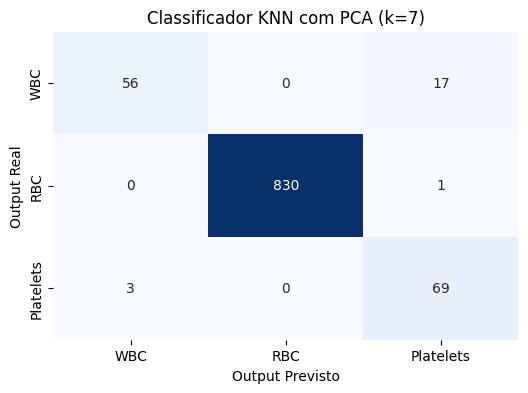

================ k = 11 =================
Resultados - Classificador KNN com PCA (k=11)
              precision    recall  f1-score   support

           0     0.9667    0.7945    0.8722        73
           1     1.0000    0.9988    0.9994       831
           2     0.8140    0.9722    0.8861        72

    accuracy                         0.9816       976
   macro avg     0.9269    0.9218    0.9192       976
weighted avg     0.9838    0.9816    0.9815       976



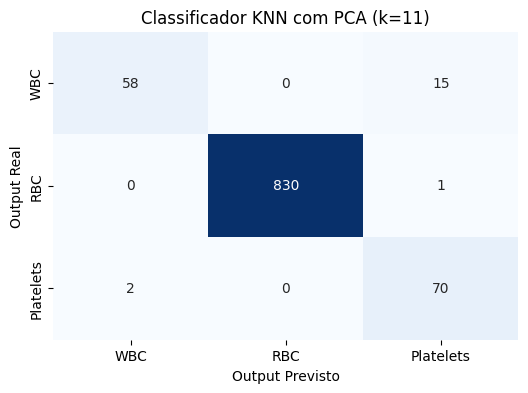

================ k = 13 =================
Resultados - Classificador KNN com PCA (k=13)
              precision    recall  f1-score   support

           0     0.9667    0.7945    0.8722        73
           1     1.0000    0.9988    0.9994       831
           2     0.8140    0.9722    0.8861        72

    accuracy                         0.9816       976
   macro avg     0.9269    0.9218    0.9192       976
weighted avg     0.9838    0.9816    0.9815       976



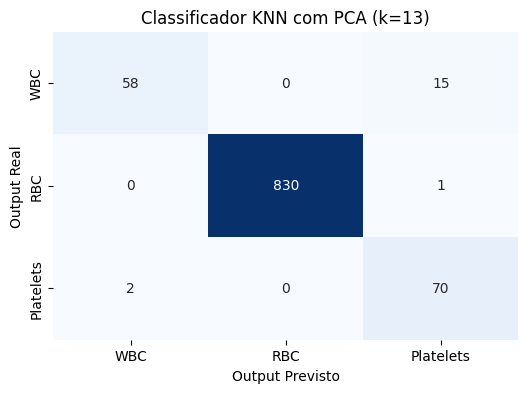

In [27]:
k_neighbors = [5, 7, 11, 13]

for k in k_neighbors:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_pca, y_train)
    y_pred_knn_pca = knn_clf.predict(X_test_pca)

    print(f"================ k = {k} =================")
    print(f"Resultados - Classificador KNN com PCA (k={k})")
    print(classification_report(y_test, y_pred_knn_pca, digits=4))
    plot_confusion_matrix(y_test, y_pred_knn_pca, f"Classificador KNN com PCA (k={k})")

================ kernel = linear =================
Resultados - Classificador SVM com vetores originais (kernel=linear)
              precision    recall  f1-score   support

           0     1.0000    0.9726    0.9861        73
           1     1.0000    1.0000    1.0000       831
           2     0.9730    1.0000    0.9863        72

    accuracy                         0.9980       976
   macro avg     0.9910    0.9909    0.9908       976
weighted avg     0.9980    0.9980    0.9980       976



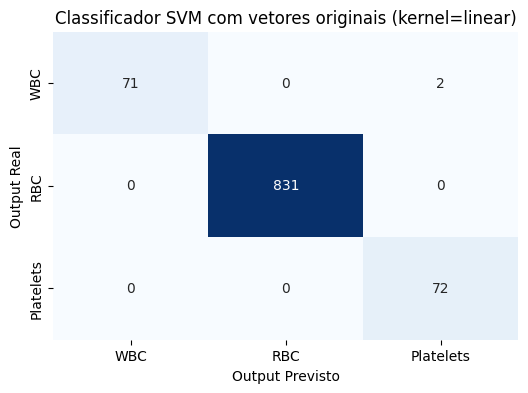

================ kernel = rbf =================
Resultados - Classificador SVM com vetores originais (kernel=rbf)
              precision    recall  f1-score   support

           0     0.9474    0.9863    0.9664        73
           1     1.0000    1.0000    1.0000       831
           2     0.9855    0.9444    0.9645        72

    accuracy                         0.9949       976
   macro avg     0.9776    0.9769    0.9770       976
weighted avg     0.9950    0.9949    0.9949       976



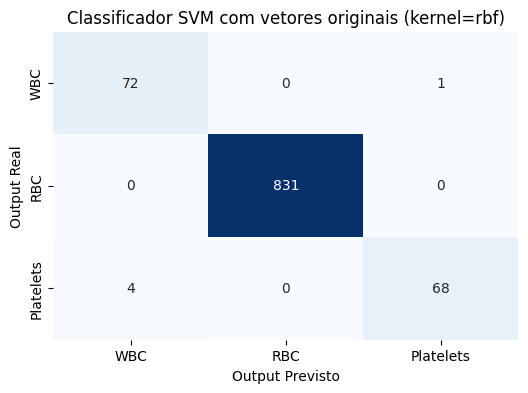

================ kernel = poly =================
Resultados - Classificador SVM com vetores originais (kernel=poly)
              precision    recall  f1-score   support

           0     0.9571    0.9178    0.9371        73
           1     1.0000    1.0000    1.0000       831
           2     0.9200    0.9583    0.9388        72

    accuracy                         0.9908       976
   macro avg     0.9590    0.9587    0.9586       976
weighted avg     0.9909    0.9908    0.9908       976



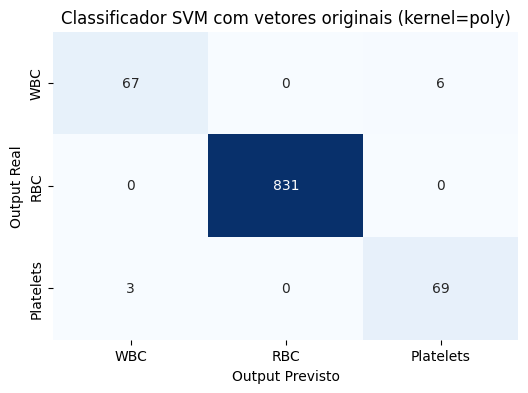

================ kernel = sigmoid =================
Resultados - Classificador SVM com vetores originais (kernel=sigmoid)
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        73
           1     0.8514    1.0000    0.9198       831
           2     0.0000    0.0000    0.0000        72

    accuracy                         0.8514       976
   macro avg     0.2838    0.3333    0.3066       976
weighted avg     0.7249    0.8514    0.7831       976



c:\Users\secol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\secol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\secol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

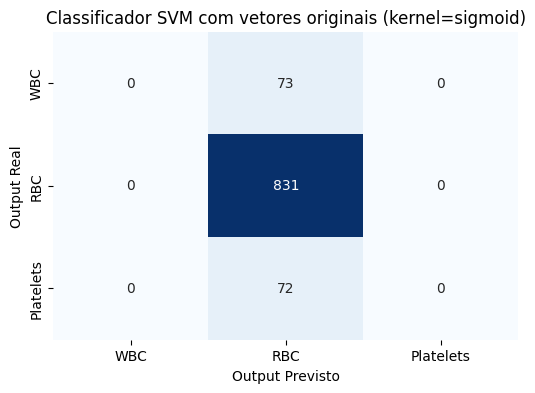

In [28]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    
    svm_flat = SVC(kernel=kernel)
    svm_flat.fit(X_train_flat, y_train)
    y_pred_flat = svm_flat.predict(X_test_flat)

    print(f"================ kernel = {kernel} =================")
    print(f"Resultados - Classificador SVM com vetores originais (kernel={kernel})")
    print(classification_report(y_test, y_pred_flat, digits=4))
    plot_confusion_matrix(y_test, y_pred_flat, f"Classificador SVM com vetores originais (kernel={kernel})")

================ kernel = linear =================
Resultados - Classificador SVM com PCA (kernel=linear)
              precision    recall  f1-score   support

           0     0.9600    0.9863    0.9730        73
           1     1.0000    1.0000    1.0000       831
           2     0.9857    0.9583    0.9718        72

    accuracy                         0.9959       976
   macro avg     0.9819    0.9815    0.9816       976
weighted avg     0.9960    0.9959    0.9959       976



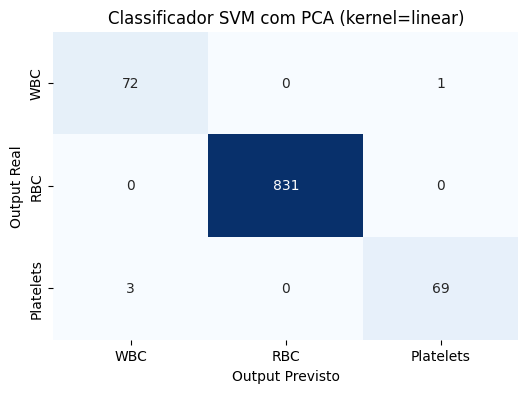

================ kernel = rbf =================
Resultados - Classificador SVM com PCA (kernel=rbf)
              precision    recall  f1-score   support

           0     0.9351    0.9863    0.9600        73
           1     1.0000    1.0000    1.0000       831
           2     0.9853    0.9306    0.9571        72

    accuracy                         0.9939       976
   macro avg     0.9735    0.9723    0.9724       976
weighted avg     0.9941    0.9939    0.9938       976



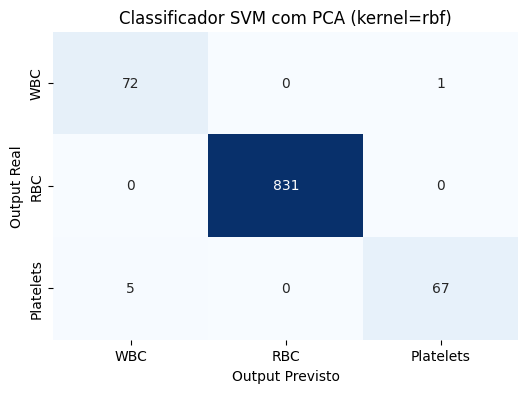

================ kernel = poly =================
Resultados - Classificador SVM com PCA (kernel=poly)
              precision    recall  f1-score   support

           0     0.9726    0.9726    0.9726        73
           1     1.0000    1.0000    1.0000       831
           2     0.9722    0.9722    0.9722        72

    accuracy                         0.9959       976
   macro avg     0.9816    0.9816    0.9816       976
weighted avg     0.9959    0.9959    0.9959       976



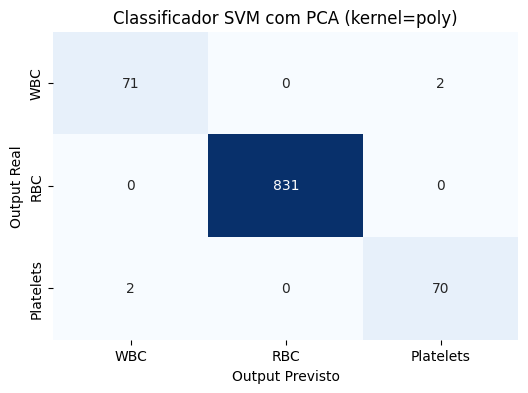

================ kernel = sigmoid =================
Resultados - Classificador SVM com PCA (kernel=sigmoid)
              precision    recall  f1-score   support

           0     0.7101    0.6712    0.6901        73
           1     0.9976    0.9976    0.9976       831
           2     0.6842    0.7222    0.7027        72

    accuracy                         0.9529       976
   macro avg     0.7973    0.7970    0.7968       976
weighted avg     0.9530    0.9529    0.9528       976



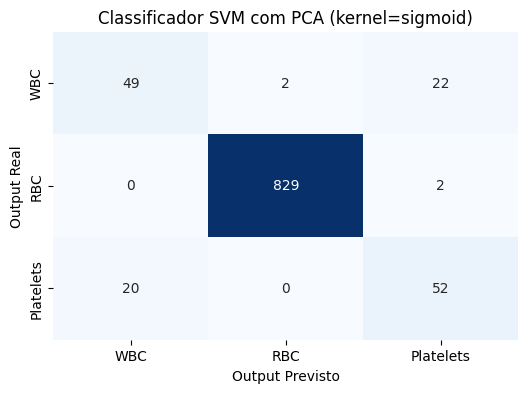

In [29]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    svm_pca = SVC(kernel=kernel)
    svm_pca.fit(X_train_pca, y_train)
    y_pred_pca = svm_pca.predict(X_test_pca)

    print(f"================ kernel = {kernel} =================")
    print(f"Resultados - Classificador SVM com PCA (kernel={kernel})")
    print(classification_report(y_test, y_pred_pca, digits=4))
    plot_confusion_matrix(y_test, y_pred_pca, f"Classificador SVM com PCA (kernel={kernel})")

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
X_train_arr_torch = torch.tensor(np.transpose(X_train_arr, (0,3,1,2)), dtype=torch.float32)
X_test_arr_torch = torch.tensor(np.transpose(X_test_arr, (0,3,1,2)), dtype=torch.float32)

X_train_flat_torch = torch.tensor(X_train_flat, dtype=torch.float32)
X_test_flat_torch = torch.tensor(X_test_flat, dtype=torch.float32)
X_train_pca_torch = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_pca_torch = torch.tensor(X_test_pca, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [33]:
batch_size = 32

train_dataset_flat = TensorDataset(X_train_flat_torch, y_train_torch)
test_dataset_flat = TensorDataset(X_test_flat_torch, y_test_torch)

train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)

train_dataset_pca = TensorDataset(X_train_pca_torch, y_train_torch)
test_dataset_pca = TensorDataset(X_test_pca_torch, y_test_torch)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

train_dataset_arr = TensorDataset(X_train_arr_torch, y_train_torch)
test_dataset_arr = TensorDataset(X_test_arr_torch, y_test_torch)

train_loader_arr = DataLoader(train_dataset_arr, batch_size=batch_size, shuffle=True)
test_loader_arr = DataLoader(test_dataset_arr, batch_size=batch_size, shuffle=False)

In [34]:
class BasicMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=3):
        super(BasicMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [80]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [51]:
model_flat = BasicMLP(input_dim=3888).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_flat.parameters(), lr=1e-3)

Epoch [1/300] - Train Loss: 0.4355, Val Loss: 0.2177
Epoch [2/300] - Train Loss: 0.1677, Val Loss: 0.1618
Epoch [3/300] - Train Loss: 0.0964, Val Loss: 0.1004
Epoch [4/300] - Train Loss: 0.0636, Val Loss: 0.0521
Epoch [5/300] - Train Loss: 0.0506, Val Loss: 0.0564
Epoch [6/300] - Train Loss: 0.0420, Val Loss: 0.0428
Epoch [7/300] - Train Loss: 0.0508, Val Loss: 0.0323
Epoch [8/300] - Train Loss: 0.0393, Val Loss: 0.0584
Epoch [9/300] - Train Loss: 0.0356, Val Loss: 0.0287
Epoch [10/300] - Train Loss: 0.0401, Val Loss: 0.0256
Epoch [11/300] - Train Loss: 0.0316, Val Loss: 0.0283
Epoch [12/300] - Train Loss: 0.0350, Val Loss: 0.0453
Epoch [13/300] - Train Loss: 0.0341, Val Loss: 0.0676
Epoch [14/300] - Train Loss: 0.0364, Val Loss: 0.0307
Epoch [15/300] - Train Loss: 0.0289, Val Loss: 0.0794
Epoch [16/300] - Train Loss: 0.0531, Val Loss: 0.0455
Epoch [17/300] - Train Loss: 0.0382, Val Loss: 0.0523
Epoch [18/300] - Train Loss: 0.0332, Val Loss: 0.0309
Epoch [19/300] - Train Loss: 0.0309, 

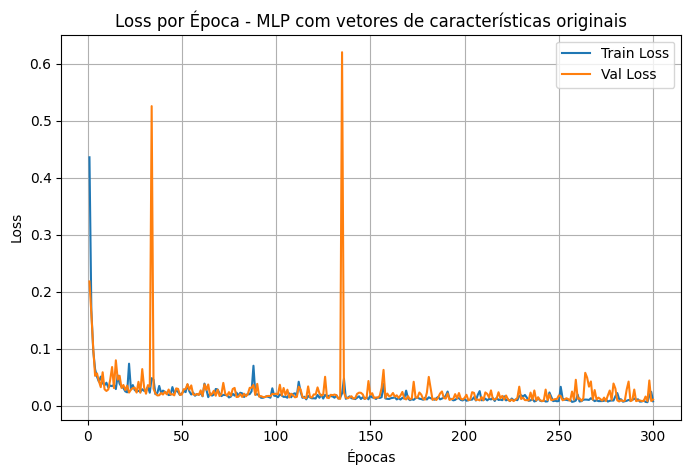

              precision    recall  f1-score   support

           0     0.9600    0.9863    0.9730        73
           1     1.0000    1.0000    1.0000       831
           2     0.9857    0.9583    0.9718        72

    accuracy                         0.9959       976
   macro avg     0.9819    0.9815    0.9816       976
weighted avg     0.9960    0.9959    0.9959       976



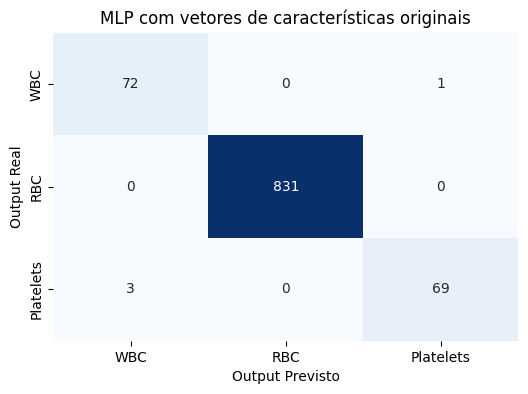

In [52]:
num_epochs = 300
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_flat, train_loader_flat, optimizer, criterion)
    val_loss, val_acc = evaluate(model_flat, test_loader_flat, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_flat.state_dict(), best_model_path)

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época - MLP com vetores de características originais')
plt.grid(True)
plt.legend()
plt.show()

model_flat.load_state_dict(torch.load(best_model_path))
model_flat.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X, y in test_loader_flat:
        X, y = X.to(device), y.to(device)
        outputs = model_flat(X)
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, digits=4))
plot_confusion_matrix(y_true_list, y_pred_list, "MLP com vetores de características originais")

In [59]:
model_pca = BasicMLP(input_dim=99).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=1e-3)

Epoch [1/60] - Train Loss: 0.4426, Val Loss: 0.1086
Epoch [2/60] - Train Loss: 0.0570, Val Loss: 0.0369
Epoch [3/60] - Train Loss: 0.0251, Val Loss: 0.0238
Epoch [4/60] - Train Loss: 0.0171, Val Loss: 0.0199
Epoch [5/60] - Train Loss: 0.0134, Val Loss: 0.0160
Epoch [6/60] - Train Loss: 0.0112, Val Loss: 0.0142
Epoch [7/60] - Train Loss: 0.0096, Val Loss: 0.0128
Epoch [8/60] - Train Loss: 0.0085, Val Loss: 0.0114
Epoch [9/60] - Train Loss: 0.0075, Val Loss: 0.0104
Epoch [10/60] - Train Loss: 0.0066, Val Loss: 0.0099
Epoch [11/60] - Train Loss: 0.0059, Val Loss: 0.0095
Epoch [12/60] - Train Loss: 0.0054, Val Loss: 0.0085
Epoch [13/60] - Train Loss: 0.0049, Val Loss: 0.0081
Epoch [14/60] - Train Loss: 0.0043, Val Loss: 0.0081
Epoch [15/60] - Train Loss: 0.0038, Val Loss: 0.0074
Epoch [16/60] - Train Loss: 0.0036, Val Loss: 0.0075
Epoch [17/60] - Train Loss: 0.0032, Val Loss: 0.0072
Epoch [18/60] - Train Loss: 0.0030, Val Loss: 0.0069
Epoch [19/60] - Train Loss: 0.0026, Val Loss: 0.0072
Ep

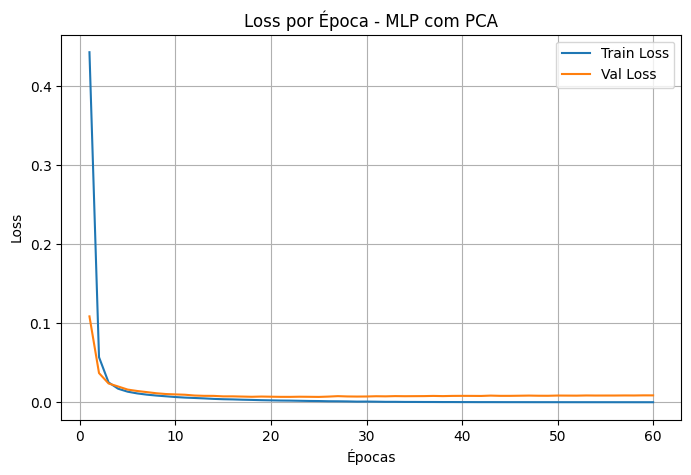

              precision    recall  f1-score   support

           0     0.9865    1.0000    0.9932        73
           1     1.0000    0.9988    0.9994       831
           2     0.9861    0.9861    0.9861        72

    accuracy                         0.9980       976
   macro avg     0.9909    0.9950    0.9929       976
weighted avg     0.9980    0.9980    0.9980       976



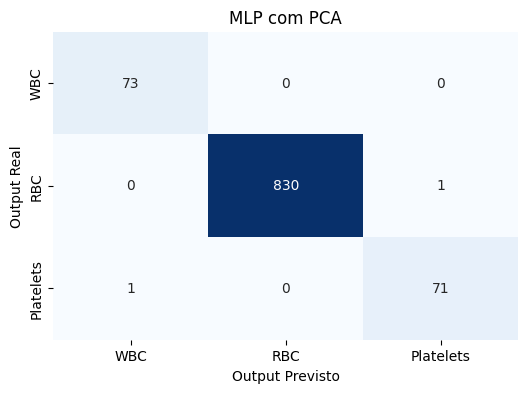

In [60]:
num_epochs = 60
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_pca, train_loader_pca, optimizer, criterion)
    val_loss, val_acc = evaluate(model_pca, test_loader_pca, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pca.state_dict(), best_model_path)

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época - MLP com PCA')
plt.grid(True)
plt.legend()
plt.show()

model_pca.load_state_dict(torch.load(best_model_path))
model_pca.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X, y in test_loader_pca:
        X, y = X.to(device), y.to(device)
        outputs = model_pca(X)
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, digits=4))
plot_confusion_matrix(y_true_list, y_pred_list, "MLP com PCA")

In [65]:
model_deep_flat = DeepMLP(input_dim=3888).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deep_flat.parameters(), lr=1e-3)

Epoch [1/300] - Train Loss: 0.3687, Val Loss: 0.1238
Epoch [2/300] - Train Loss: 0.1299, Val Loss: 0.0893
Epoch [3/300] - Train Loss: 0.0890, Val Loss: 0.0722
Epoch [4/300] - Train Loss: 0.1244, Val Loss: 0.0628
Epoch [5/300] - Train Loss: 0.0678, Val Loss: 0.0559
Epoch [6/300] - Train Loss: 0.0887, Val Loss: 0.1332
Epoch [7/300] - Train Loss: 0.0655, Val Loss: 0.0509
Epoch [8/300] - Train Loss: 0.0894, Val Loss: 0.1860
Epoch [9/300] - Train Loss: 0.0847, Val Loss: 0.0551
Epoch [10/300] - Train Loss: 0.0637, Val Loss: 0.0432
Epoch [11/300] - Train Loss: 0.0501, Val Loss: 0.0703
Epoch [12/300] - Train Loss: 0.0966, Val Loss: 0.0502
Epoch [13/300] - Train Loss: 0.0913, Val Loss: 0.0488
Epoch [14/300] - Train Loss: 0.0588, Val Loss: 0.0402
Epoch [15/300] - Train Loss: 0.0450, Val Loss: 0.0328
Epoch [16/300] - Train Loss: 0.0419, Val Loss: 0.0589
Epoch [17/300] - Train Loss: 0.0490, Val Loss: 0.0567
Epoch [18/300] - Train Loss: 0.0691, Val Loss: 0.0882
Epoch [19/300] - Train Loss: 0.0410, 

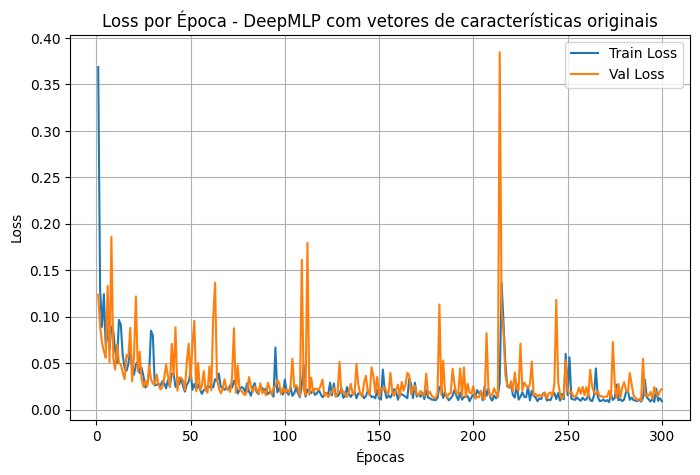

              precision    recall  f1-score   support

           0     0.9467    0.9726    0.9595        73
           1     1.0000    0.9988    0.9994       831
           2     0.9577    0.9444    0.9510        72

    accuracy                         0.9928       976
   macro avg     0.9681    0.9719    0.9700       976
weighted avg     0.9929    0.9928    0.9928       976



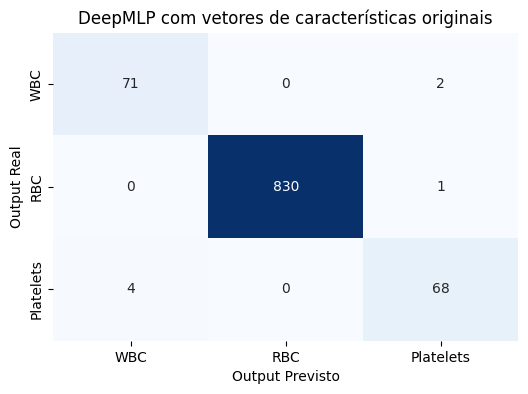

In [66]:
num_epochs = 300
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_deep_flat, train_loader_flat, optimizer, criterion)
    val_loss, val_acc = evaluate(model_deep_flat, test_loader_flat, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_deep_flat.state_dict(), best_model_path)

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época - DeepMLP com vetores de características originais')
plt.grid(True)
plt.legend()
plt.show()

model_deep_flat.load_state_dict(torch.load(best_model_path))
model_deep_flat.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X, y in test_loader_flat:
        X, y = X.to(device), y.to(device)
        outputs = model_deep_flat(X)
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, digits=4))
plot_confusion_matrix(y_true_list, y_pred_list, "DeepMLP com vetores de características originais")

In [71]:
model_pca = DeepMLP(input_dim=99).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=1e-3)

Epoch [1/20] - Train Loss: 0.1339, Val Loss: 0.0189
Epoch [2/20] - Train Loss: 0.0173, Val Loss: 0.0161
Epoch [3/20] - Train Loss: 0.0093, Val Loss: 0.0075
Epoch [4/20] - Train Loss: 0.0059, Val Loss: 0.0073
Epoch [5/20] - Train Loss: 0.0042, Val Loss: 0.0062
Epoch [6/20] - Train Loss: 0.0039, Val Loss: 0.0054
Epoch [7/20] - Train Loss: 0.0034, Val Loss: 0.0105
Epoch [8/20] - Train Loss: 0.0019, Val Loss: 0.0118
Epoch [9/20] - Train Loss: 0.0016, Val Loss: 0.0115
Epoch [10/20] - Train Loss: 0.0006, Val Loss: 0.0105
Epoch [11/20] - Train Loss: 0.0011, Val Loss: 0.0105
Epoch [12/20] - Train Loss: 0.0013, Val Loss: 0.0128
Epoch [13/20] - Train Loss: 0.0005, Val Loss: 0.0170
Epoch [14/20] - Train Loss: 0.0003, Val Loss: 0.0157
Epoch [15/20] - Train Loss: 0.0001, Val Loss: 0.0153
Epoch [16/20] - Train Loss: 0.0001, Val Loss: 0.0152
Epoch [17/20] - Train Loss: 0.0000, Val Loss: 0.0152
Epoch [18/20] - Train Loss: 0.0000, Val Loss: 0.0153
Epoch [19/20] - Train Loss: 0.0000, Val Loss: 0.0153
Ep

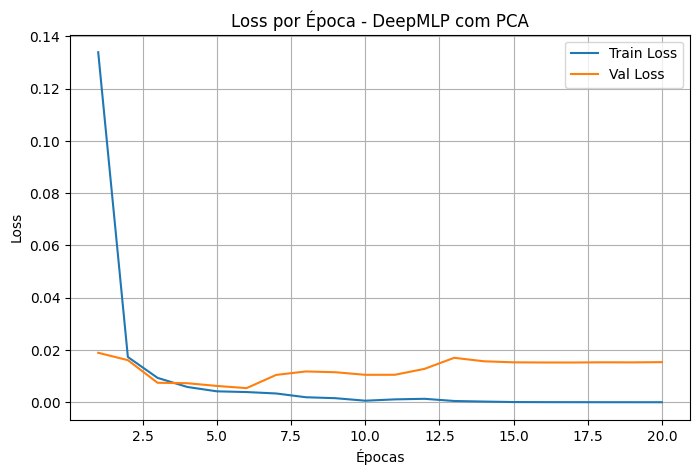

              precision    recall  f1-score   support

           0     0.9733    1.0000    0.9865        73
           1     1.0000    1.0000    1.0000       831
           2     1.0000    0.9722    0.9859        72

    accuracy                         0.9980       976
   macro avg     0.9911    0.9907    0.9908       976
weighted avg     0.9980    0.9980    0.9980       976



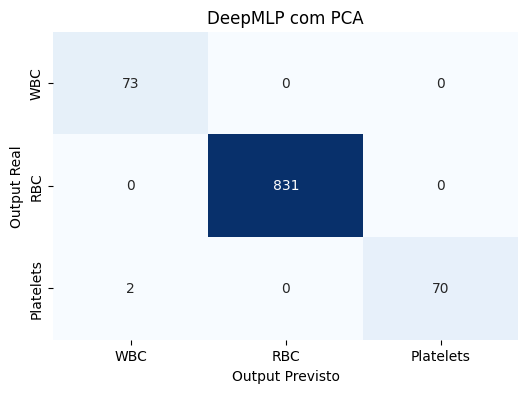

In [72]:
num_epochs = 20
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_pca, train_loader_pca, optimizer, criterion)
    val_loss, val_acc = evaluate(model_pca, test_loader_pca, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pca.state_dict(), best_model_path)

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época - DeepMLP com PCA')
plt.grid(True)
plt.legend()
plt.show()

model_pca.load_state_dict(torch.load(best_model_path))
model_pca.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X, y in test_loader_pca:
        X, y = X.to(device), y.to(device)
        outputs = model_pca(X)
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, digits=4))
plot_confusion_matrix(y_true_list, y_pred_list, "DeepMLP com PCA")

In [91]:
model_cnn = CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

Epoch [1/100] - Train Loss: 0.4076, Val Loss: 0.2040, Val Acc: 0.9293
Melhor modelo salvo.
Epoch [2/100] - Train Loss: 0.0923, Val Loss: 0.0623, Val Acc: 0.9764
Melhor modelo salvo.
Epoch [3/100] - Train Loss: 0.0444, Val Loss: 0.0677, Val Acc: 0.9795
Epoch [4/100] - Train Loss: 0.0440, Val Loss: 0.0622, Val Acc: 0.9703
Melhor modelo salvo.
Epoch [5/100] - Train Loss: 0.0354, Val Loss: 0.0358, Val Acc: 0.9836
Melhor modelo salvo.
Epoch [6/100] - Train Loss: 0.0317, Val Loss: 0.0512, Val Acc: 0.9805
Epoch [7/100] - Train Loss: 0.0251, Val Loss: 0.0374, Val Acc: 0.9857
Epoch [8/100] - Train Loss: 0.0219, Val Loss: 0.0346, Val Acc: 0.9887
Melhor modelo salvo.
Epoch [9/100] - Train Loss: 0.0246, Val Loss: 0.0313, Val Acc: 0.9898
Melhor modelo salvo.
Epoch [10/100] - Train Loss: 0.0289, Val Loss: 0.0342, Val Acc: 0.9826
Epoch [11/100] - Train Loss: 0.0244, Val Loss: 0.0305, Val Acc: 0.9877
Melhor modelo salvo.
Epoch [12/100] - Train Loss: 0.0234, Val Loss: 0.0368, Val Acc: 0.9857
Epoch [13/

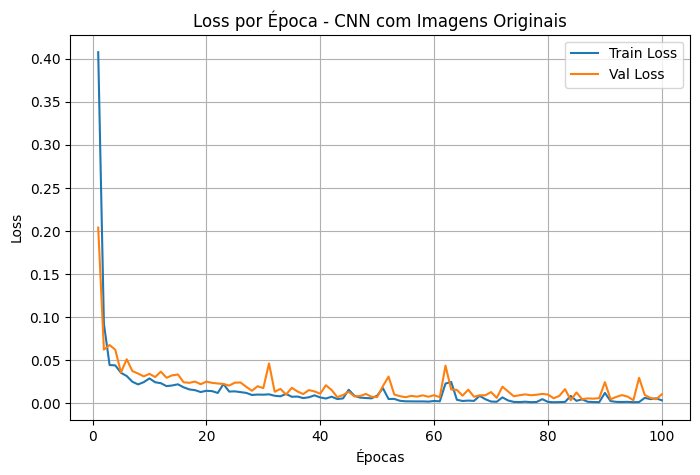

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        73
           1     1.0000    0.9988    0.9994       831
           2     0.9863    1.0000    0.9931        72

    accuracy                         0.9990       976
   macro avg     0.9954    0.9996    0.9975       976
weighted avg     0.9990    0.9990    0.9990       976



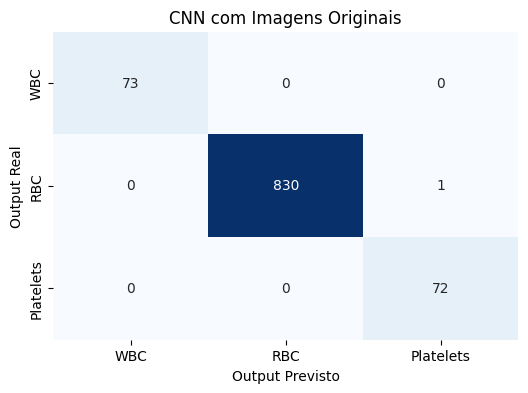

In [92]:
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = 'best_cnn_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_cnn, train_loader_arr, optimizer, criterion)
    val_loss, val_acc = evaluate(model_cnn, test_loader_arr, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_cnn.state_dict(), best_model_path)
        print("Melhor modelo salvo.")

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época - CNN com Imagens Originais')
plt.grid(True)
plt.legend()
plt.show()

model_cnn.load_state_dict(torch.load(best_model_path))
model_cnn.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X, y in test_loader_arr:
        X, y = X.to(device), y.to(device)
        outputs = model_cnn(X)
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

print(classification_report(y_true_list, y_pred_list, digits=4))
plot_confusion_matrix(y_true_list, y_pred_list, "CNN com Imagens Originais")